In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from category_encoders.one_hot import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import make_column_selector
from sklearn.metrics import make_scorer
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [72]:
ames_train = pd.read_csv('../datasets/train.csv')
ames_test = pd.read_csv('../datasets/test.csv')

In [73]:
ames_train

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2046,1587,921126030,20,RL,79.0,11449,Pave,NaN,IR1,HLS,...,0,0,NaN,NaN,NaN,0,1,2008,WD,298751
2047,785,905377130,30,RL,NaN,12342,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2009,WD,82500
2048,916,909253010,50,RL,57.0,7558,Pave,NaN,Reg,Bnk,...,0,0,NaN,NaN,NaN,0,3,2009,WD,177000
2049,639,535179160,20,RL,80.0,10400,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,11,2009,WD,144000


To start off with, let's change the column names to a more python-friendly style

In [74]:
ames_train.columns = ames_train.columns.str.lower().str.replace(' ','_')
ames_test.columns = ames_test.columns.str.lower().str.replace(' ','_')

Let's then see what nulls there are

In [75]:
ames_train.isnull().sum().sort_values(ascending=False).loc[lambda x: x>0]

pool_qc           2042
misc_feature      1986
alley             1911
fence             1651
fireplace_qu      1000
lot_frontage       330
garage_finish      114
garage_qual        114
garage_yr_blt      114
garage_cond        114
garage_type        113
bsmt_exposure       58
bsmtfin_type_2      56
bsmtfin_type_1      55
bsmt_cond           55
bsmt_qual           55
mas_vnr_area        22
mas_vnr_type        22
bsmt_half_bath       2
bsmt_full_bath       2
garage_area          1
total_bsmt_sf        1
bsmt_unf_sf          1
bsmtfin_sf_2         1
bsmtfin_sf_1         1
garage_cars          1
dtype: int64

Based on the data dictionary, pool_qc, misc_feature, alley, fence, fireplace_qu, garage_finish, garage_qual, garage_yr_blt, garage_cond, garage_type, bsmt_exposure, bsmtfin_type_2, 1, cond, qual are all encodings of 'Said feature is not present in this house' ex: 'alley' having a value of nan refers to not having alley access from the property. But some of the features, like mas_vnr_area have a 'none' value already encoded, and an extra nan not mentioned in the dictionary (see below for proof)

Therefore, the variables that need a real imputation or removal strategy instead of a method for handling nans as 'none' are: 
'lot_frontage', 'mas_vnr_area', 'mas_vnr_type', 'bsmt_half_bath', 'bsmt_full_bath', 'garage_area', 'total_bsmt_sf', 'bsmt_unf_sf', 'bsmtfin_sf_2', 'bsmtfin_sf_1', 'garage_cars'

In [76]:
ames_train['mas_vnr_type'].unique()

array(['BrkFace', 'None', nan, 'Stone', 'BrkCmn'], dtype=object)

In [77]:
ames_train['lot_frontage'].unique()

array([ nan,  43.,  68.,  73.,  82., 137.,  35.,  70.,  21.,  64., 120.,
        24.,  74.,  93.,  34.,  80.,  71.,  72., 109.,  40., 103., 100.,
        92.,  65.,  75.,  60.,  30.,  79.,  41., 105., 107.,  81.,  36.,
        63.,  32.,  94.,  44.,  50.,  48.,  67.,  88.,  83.,  53.,  58.,
        57.,  52.,  87., 134.,  56.,  54., 140.,  78.,  85.,  90.,  96.,
        62.,  49.,  59., 155.,  91.,  61.,  86., 128.,  77.,  42.,  89.,
        51.,  69.,  55., 112.,  76., 125.,  98., 113., 102.,  22., 122.,
        84., 119., 118.,  66.,  95., 108., 195., 106.,  39., 110., 130.,
        97.,  45.,  37., 123.,  38., 129., 115.,  47., 114., 104.,  46.,
       121., 124., 313., 141., 101.,  99., 160., 174.,  26., 144., 138.,
       111.,  25.,  33., 200., 150., 117., 153., 116., 135.])

ID, PID, are useless for regression/inference, and useless as an index, so we'll just remove those rows

In [78]:
ames_train.drop(columns=['id','pid'], inplace=True)
ames_test.drop(columns=['id','pid'],inplace=True)

In [79]:
ames_train['garage_cars'].unique()

array([ 2.,  1.,  3.,  0.,  4.,  5., nan])

In [80]:
ames_train['bsmtfin_sf_1'].loc[lambda x: np.isnan(x)], ames_train['garage_cars'].loc[lambda x: np.isnan(x)]

(1327   NaN
 Name: bsmtfin_sf_1, dtype: float64,
 1712   NaN
 Name: garage_cars, dtype: float64)

<AxesSubplot:xlabel='garage_qual', ylabel='garage_area'>

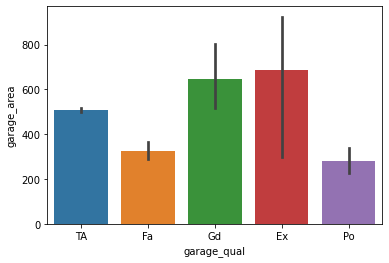

In [81]:
sns.barplot(x=ames_train['garage_qual'],y=ames_train['garage_area'])

Looking at this plot, and with the arrangement of poor to fair to typical to good to excellent, it looks like garage quality is a subjective measure that's highly correlated with garage size- and we want to avoid multicollinearity when creating models. To that effect, we can change garage_qual to simply being something along the lines of 'Is there a garage, yes or no', and keep the garage area. We want to do with the other garage factors- multiplying these variables by using OHE would greatly inflate the feature space without clear benefits- and perhaps lead to overfitting. The following graphs should be taken in that manner

<AxesSubplot:xlabel='garage_finish', ylabel='garage_area'>

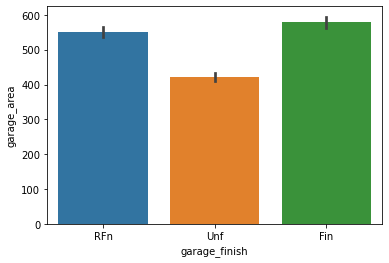

In [82]:
sns.barplot(x=ames_train['garage_finish'],y=ames_train['garage_area'])

In [83]:
ames_test2 = pd.read_csv('../datasets/test.csv')
ames_train2 = pd.read_csv('../datasets/train.csv')

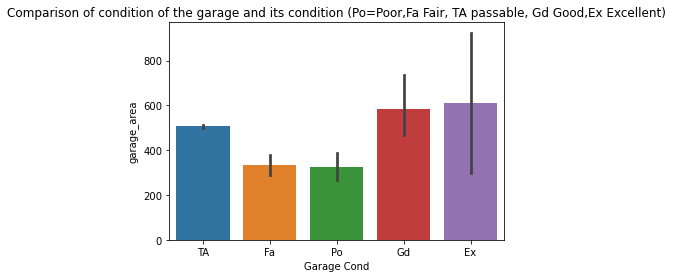

In [84]:
sns.barplot(x=ames_train2['Garage Cond'],y=ames_train['garage_area'])
plt.title('Comparison of condition of the garage and its condition (Po=Poor,Fa Fair, TA passable, Gd Good,Ex Excellent)')
plt.savefig('garage.png')

<AxesSubplot:xlabel='garage_type', ylabel='garage_area'>

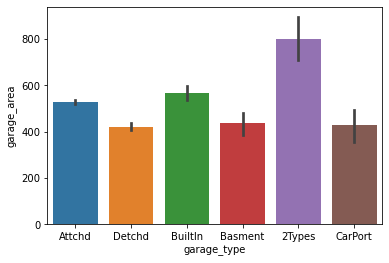

In [85]:
sns.barplot(x=ames_train['garage_type'],y=ames_train['garage_area'])

There's no real ordering pattern to the type, so we'll keep it

<AxesSubplot:xlabel='garage_yr_blt', ylabel='garage_area'>

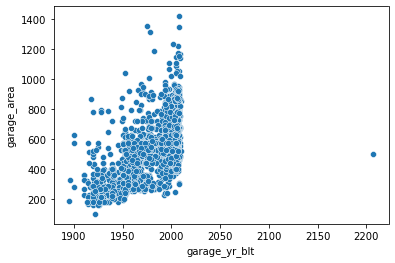

In [86]:
sns.scatterplot(x=ames_train['garage_yr_blt'],y=ames_train['garage_area'])

In [87]:
temp_ames = ames_train.dropna(axis=0, subset=['garage_yr_blt','garage_area'])
np.corrcoef(temp_ames['garage_yr_blt'],temp_ames['garage_area'])

array([[1.        , 0.55206888],
       [0.55206888, 1.        ]])

There's a R**2 of .55, and a rogue yr_blt. We'll keep it in for now, prospectively, and remove the rogue time-traveling garage

In [88]:
ames_train.drop(columns=['garage_qual','garage_finish','garage_cond',], inplace=True)
ames_test.drop(columns=['garage_qual','garage_finish','garage_cond',], inplace=True)

In [89]:
ames_train[(ames_train['garage_yr_blt']<2022) | ames_train['garage_yr_blt'].isnull()].shape


(2050, 76)

In [90]:
ames_train = ames_train[(ames_train['garage_yr_blt']<2022) | ames_train['garage_yr_blt'].isnull()]

similarly, for pools:

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='pool_qc', ylabel='pool_area'>

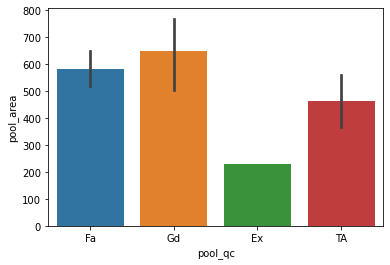

In [91]:
sns.barplot(ames_train['pool_qc'],ames_train['pool_area'])

Perhaps surprisingly, pool quality and pool size do not seem to be related- so we'll fill in the information about no pool, and continue from there

In [92]:
ames_train.loc[:,['pool_qc','misc_feature','alley','fence','fireplace_qu','garage_type','bsmt_exposure',
                  'bsmtfin_type_2','bsmtfin_type_1','bsmt_cond','bsmt_qual']]= ames_train.loc[:,['pool_qc','misc_feature','alley','fence','fireplace_qu','garage_type',
                                                                                                 'bsmt_exposure','bsmtfin_type_2','bsmtfin_type_1','bsmt_cond','bsmt_qual']].fillna('NA')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


'On the primacy of 'Location, location, location''

In [93]:
ames_train.isnull().sum().sort_values(ascending=False).loc[lambda x: x>0]

lot_frontage      330
garage_yr_blt     114
mas_vnr_type       21
mas_vnr_area       21
bsmt_full_bath      2
bsmt_half_bath      2
total_bsmt_sf       1
bsmt_unf_sf         1
bsmtfin_sf_2        1
bsmtfin_sf_1        1
garage_cars         1
garage_area         1
dtype: int64

In [94]:
ames_test.loc[:,['pool_qc','misc_feature','alley','fence','fireplace_qu','garage_type','bsmt_exposure',
                  'bsmtfin_type_2','bsmtfin_type_1','bsmt_cond','bsmt_qual']]= ames_test.loc[:,['pool_qc','misc_feature','alley','fence','fireplace_qu','garage_type',
                                                                                                 'bsmt_exposure','bsmtfin_type_2','bsmtfin_type_1','bsmt_cond','bsmt_qual']].fillna('NA')

In [95]:
ames_train.isnull().sum().sort_values(ascending=False).loc[lambda x: x>0]

lot_frontage      330
garage_yr_blt     114
mas_vnr_type       21
mas_vnr_area       21
bsmt_full_bath      2
bsmt_half_bath      2
total_bsmt_sf       1
bsmt_unf_sf         1
bsmtfin_sf_2        1
bsmtfin_sf_1        1
garage_cars         1
garage_area         1
dtype: int64

In [96]:
ames_train['mas_vnr_type'].fillna('None',inplace=True)
ames_test['mas_vnr_type'].fillna('None',inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [97]:
ames_train['mas_vnr_area'].fillna(0,inplace=True)
ames_test['mas_vnr_area'].fillna(0,inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year_built', ylabel='garage_yr_blt'>

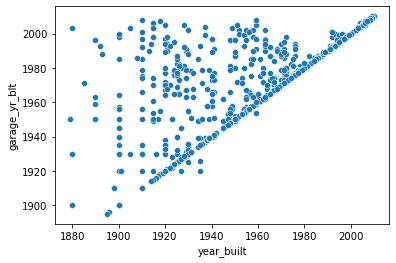

In [98]:
tem_pames =ames_train.dropna(axis=0, subset=['garage_yr_blt','year_built'])
sns.scatterplot(tem_pames['year_built'],tem_pames['garage_yr_blt'])

On further thought, it seems that there's no fair way to impute the year built data when we actually know what the data is, it's just inexpressible in this format. At best, putting it as the mean of the data with a simple imputer would somewhat neutralize its impact on that condition, but it might be better to just drop it. The rest can be simple imputed

In [99]:
ames_train.drop(columns=['garage_yr_blt'],inplace=True)
ames_test.drop(columns=['garage_yr_blt'],inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


For linearity reasons, total_bsmt_sf = bsmt_unf_sf+bsmtfin_sf_2+bsmtfin_sf_1, so we should remove one column to make sure we're not duplicating data. In this case, let's remove bsmt_unf_sf

In [100]:
ames_train.drop(columns=['bsmt_unf_sf'],inplace=True)
ames_test.drop(columns=['bsmt_unf_sf'],inplace=True)

If you use a **SimpleImputer**, you will convert all your columns into objects, which makes one-hot-encoding much more difficult. Since we can remove linear problems by using a lasso/ridge framework before using a linear model, we need not worry about issues of dropping a column, so the category_encoders OneHotEncoder will work better. Then, you can drop the other NAs that aren't lot_frontage

In [101]:
ames_train['lot_frontage'].fillna(ames_train['lot_frontage'].mean(),inplace=True)
ames_test['lot_frontage'].fillna(ames_train['lot_frontage'].mean(),inplace=True)
ames_train.dropna(inplace=True)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [102]:
ames_train.isnull().sum().sort_values(ascending=False).loc[lambda x: x>0]

Series([], dtype: int64)

ms_subclass is not something with actual numerical data, but a description of what the house type is

In [103]:
ames_train['ms_subclass'] = ames_train['ms_subclass'].astype(str)

C:\Users\Karthik\AppData\Local\Temp/ipykernel_2996/2781934380.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ames_train['ms_subclass'] = ames_train['ms_subclass'].astype(str)


In [104]:
X = ames_train.drop(columns='saleprice')
y = ames_train['saleprice']
X_train, X_val, y_train, y_val = train_test_split(X,y,random_state=815)

In [105]:
X_train.columns

Index(['ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area', 'street',
       'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config',
       'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type',
       'house_style', 'overall_qual', 'overall_cond', 'year_built',
       'year_remod/add', 'roof_style', 'roof_matl', 'exterior_1st',
       'exterior_2nd', 'mas_vnr_type', 'mas_vnr_area', 'exter_qual',
       'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
       'bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2',
       'total_bsmt_sf', 'heating', 'heating_qc', 'central_air', 'electrical',
       '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area',
       'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath',
       'bedroom_abvgr', 'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd',
       'functional', 'fireplaces', 'fireplace_qu', 'garage_type',
       'garage_cars', 'garage_area', 'paved_drive', 'wood_dec

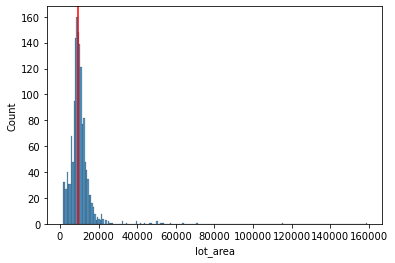

In [106]:
sns.histplot(X_train,x='lot_area')
plt.axvline(X_train['lot_area'].median(),color='r')


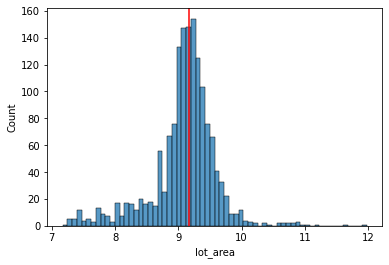

In [107]:
sns.histplot(np.log(X_train['lot_area']))
plt.axvline(np.log(X_train['lot_area']).median(),color='r')


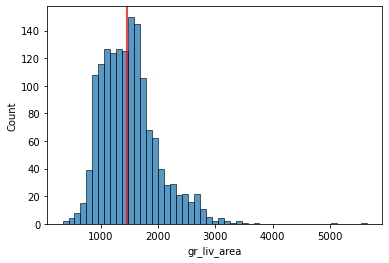

In [108]:
sns.histplot(X_train['gr_liv_area'])
plt.axvline(X_train['gr_liv_area'].median(),color='r')

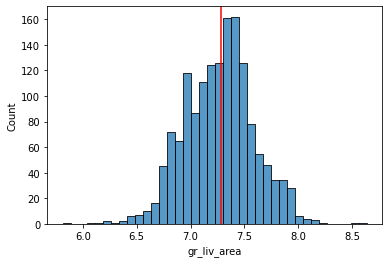

In [109]:
sns.histplot(np.log(X_train['gr_liv_area']))
plt.axvline(np.log(X_train['gr_liv_area'].median()),color='r')
#plt.axvline(X_train['gr_liv_area'].mean(),color='k')

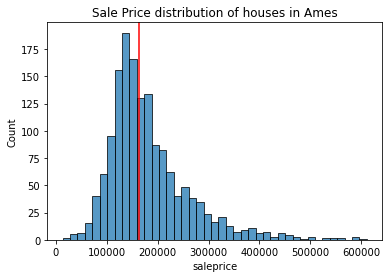

In [110]:
sns.histplot(y_train)
plt.axvline(y_train.median(),color='r')
plt.title('Sale Price distribution of houses in Ames')
plt.savefig('sales.png')

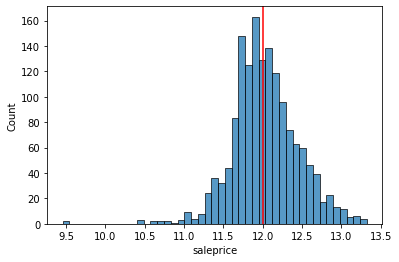

In [111]:
sns.histplot(np.log(y_train))
plt.axvline(np.log(y_train).median(),color='r')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='gr_liv_area', ylabel='saleprice'>

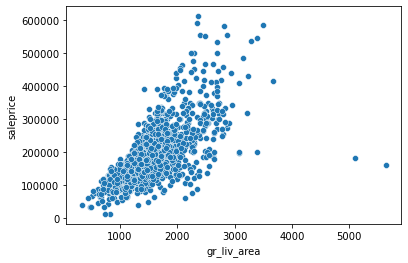

In [112]:
sns.scatterplot(X_train['gr_liv_area'],y_train)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


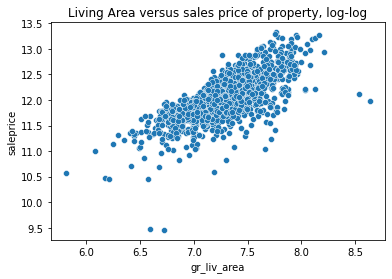

In [113]:
sns.scatterplot(np.log(X_train['gr_liv_area']),np.log(y_train))
plt.title('Living Area versus sales price of property, log-log')
plt.savefig('liver.png')

Lots of basic parts of economics suggest that a log model is best for modeling incomes, areas, etc. As this graph shows, the data tends to not be perfectly normal- aand if you compare a simple living area to salesprice- taking the log of both sides removes the 'fan-shape' residuals. To fix this, we'll take the log of the 2 X values mentioned and use a ttr transform on the saleprice

In [114]:
X_train['gr_liv_area'] = np.log(X_train['gr_liv_area'])

In [115]:
X_val['gr_liv_area'] = np.log(X_val['gr_liv_area'])
ames_test['gr_liv_area'] = np.log(ames_test['gr_liv_area'])

In [116]:
X_train['lot_area'] = np.log(X_train['lot_area'])
X_val['lot_area'] = np.log(X_val['lot_area'])
ames_test['lot_area'] = np.log(ames_test['lot_area'])

In [117]:
ohe = OneHotEncoder()

In [118]:
ss =StandardScaler()

In [119]:
rfe = RFE(LinearRegression(),n_features_to_select=.4)

In [146]:
pf = PolynomialFeatures(interaction_only=True)

In [120]:
lr = LinearRegression()
tt = TransformedTargetRegressor(regressor=LinearRegression(),func=np.log, inverse_func = np.exp)

In [121]:
pipe = make_pipeline(ohe,ss,rfe,lr)

In [122]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['ms_subclass', 'ms_zoning', 'street',
                                     'alley', 'lot_shape', 'land_contour',
                                     'utilities', 'lot_config', 'land_slope',
                                     'neighborhood', 'condition_1',
                                     'condition_2', 'bldg_type', 'house_style',
                                     'roof_style', 'roof_matl', 'exterior_1st',
                                     'exterior_2nd', 'mas_vnr_type',
                                     'exter_qual', 'exter_cond', 'foundation',
                                     'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
                                     'bsmtfin_type_1', 'bsmtfin_type_2',
                                     'heating', 'heating_qc', 'central_air', ...])),
                ('standardscaler', StandardScaler()),
                ('rfe',
                 RFE(estimator=LinearRegressio

In [123]:
pipe.score(X_train,y_train)

0.6980393220970051

In [124]:
pipe.score(X_val,y_val)

-1.1094047911896739e+25

In [125]:
y_pred_pipe = pipe.predict(X_train)

In [126]:
lr.fit(X_train[['gr_liv_area']],y_train)
lr.score(X_val[['gr_liv_area']],y_val), lr.score(X_train[['gr_liv_area']],y_train)

(0.5337184877429955, 0.46952855554473205)

In [127]:
X_test = ames_test

Above is to stop messing with ames_test, and simply deal with this new X_test for whatever needs to be done

In [128]:
tt.fit(X_train[['gr_liv_area']],y_train)
tt.score(X_train[['gr_liv_area']],y_train), tt.score(X_val[['gr_liv_area']],y_val)

(0.46402318626226036, 0.546435207554491)

So, after a broad approach like that failed, let's try and slim it down substantially to more likely to be relevant variables

<AxesSubplot:>

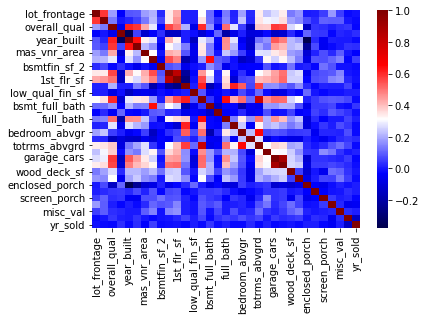

In [129]:
sns.heatmap(X_train.corr(),cmap='seismic')

In [130]:
X_train.columns

Index(['ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area', 'street',
       'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config',
       'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type',
       'house_style', 'overall_qual', 'overall_cond', 'year_built',
       'year_remod/add', 'roof_style', 'roof_matl', 'exterior_1st',
       'exterior_2nd', 'mas_vnr_type', 'mas_vnr_area', 'exter_qual',
       'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
       'bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2',
       'total_bsmt_sf', 'heating', 'heating_qc', 'central_air', 'electrical',
       '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area',
       'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath',
       'bedroom_abvgr', 'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd',
       'functional', 'fireplaces', 'fireplace_qu', 'garage_type',
       'garage_cars', 'garage_area', 'paved_drive', 'wood_dec

Let's drop mo sold/yr sold and make it a simple months since 1990 - better for time effects

In [131]:
X_train['mo_since_1990'] = X_train['mo_sold']+12*X_train['yr_sold']-1990*12

In [132]:
X_val['mo_since_1990'] = X_val['mo_sold']+12*X_val['yr_sold']-1990*12
X_test['mo_since_1990'] = X_test['mo_sold']+12*X_test['yr_sold']-1990*12

In [133]:
X_train.drop(columns=['mo_sold','yr_sold'],inplace=True)
X_val.drop(columns=['mo_sold','yr_sold'],inplace=True)
X_test.drop(columns=['mo_sold','yr_sold'],inplace=True)

In [134]:
X_train.columns

Index(['ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area', 'street',
       'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config',
       'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type',
       'house_style', 'overall_qual', 'overall_cond', 'year_built',
       'year_remod/add', 'roof_style', 'roof_matl', 'exterior_1st',
       'exterior_2nd', 'mas_vnr_type', 'mas_vnr_area', 'exter_qual',
       'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
       'bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2',
       'total_bsmt_sf', 'heating', 'heating_qc', 'central_air', 'electrical',
       '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area',
       'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath',
       'bedroom_abvgr', 'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd',
       'functional', 'fireplaces', 'fireplace_qu', 'garage_type',
       'garage_cars', 'garage_area', 'paved_drive', 'wood_dec

In [135]:

X_train.drop(columns=['ms_subclass','lot_frontage','street','alley','lot_shape','land_contour','land_slope','condition_1','condition_2','house_style','overall_qual','overall_cond',
                      'year_remod/add','roof_style','roof_matl','exterior_1st','exterior_2nd','mas_vnr_type','mas_vnr_area','exter_qual','exter_cond','foundation','bsmt_qual','bsmt_cond','bsmt_exposure',
                      'bsmt_exposure','bsmtfin_type_1','bsmtfin_sf_1','bsmtfin_type_2','bsmtfin_sf_2','heating_qc','electrical','low_qual_fin_sf','kitchen_qual','functional','fireplace_qu','wood_deck_sf','open_porch_sf',
                      'enclosed_porch','3ssn_porch'
                     ],inplace=True)

In [136]:
X_val.drop(columns=['ms_subclass','lot_frontage','street','alley','lot_shape','land_contour','land_slope','condition_1','condition_2','house_style','overall_qual','overall_cond',
                      'year_remod/add','roof_style','roof_matl','exterior_1st','exterior_2nd','mas_vnr_type','mas_vnr_area','exter_qual','exter_cond','foundation','bsmt_qual','bsmt_cond','bsmt_exposure',
                      'bsmt_exposure','bsmtfin_type_1','bsmtfin_sf_1','bsmtfin_type_2','bsmtfin_sf_2','heating_qc','electrical','low_qual_fin_sf','kitchen_qual','functional','fireplace_qu','wood_deck_sf','open_porch_sf',
                      'enclosed_porch','3ssn_porch'
                     ],inplace=True)
X_test.drop(columns=['ms_subclass','lot_frontage','street','alley','lot_shape','land_contour','land_slope','condition_1','condition_2','house_style','overall_qual','overall_cond',
                      'year_remod/add','roof_style','roof_matl','exterior_1st','exterior_2nd','mas_vnr_type','mas_vnr_area','exter_qual','exter_cond','foundation','bsmt_qual','bsmt_cond','bsmt_exposure',
                      'bsmt_exposure','bsmtfin_type_1','bsmtfin_sf_1','bsmtfin_type_2','bsmtfin_sf_2','heating_qc','electrical','low_qual_fin_sf','kitchen_qual','functional','fireplace_qu','wood_deck_sf','open_porch_sf',
                      'enclosed_porch','3ssn_porch'
                     ],inplace=True)

The features I dropped were more about sense of what features made sense in prediction value and trying to lower collinearity based on overly similar ideas

<AxesSubplot:>

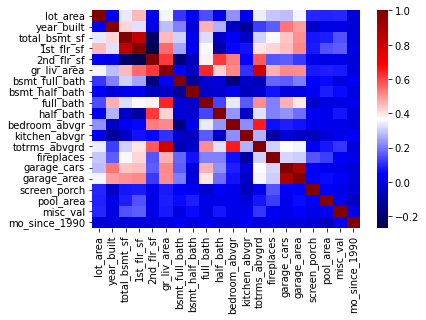

In [137]:
sns.heatmap(X_train.corr(),cmap='seismic')

In [141]:
X_train.columns

Index(['ms_zoning', 'lot_area', 'utilities', 'lot_config', 'neighborhood',
       'bldg_type', 'year_built', 'total_bsmt_sf', 'heating', 'central_air',
       '1st_flr_sf', '2nd_flr_sf', 'gr_liv_area', 'bsmt_full_bath',
       'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr',
       'kitchen_abvgr', 'totrms_abvgrd', 'fireplaces', 'garage_type',
       'garage_cars', 'garage_area', 'paved_drive', 'screen_porch',
       'pool_area', 'pool_qc', 'fence', 'misc_feature', 'misc_val',
       'sale_type', 'mo_since_1990'],
      dtype='object')

Lets' set up a real baseline

In [243]:
X_baseline=ames_train[['gr_liv_area']]
y_baseline=ames_train['saleprice']
linreg= LinearRegression()
linreg.fit(X_baseline,y_baseline)
y_basepreds = linreg.predict(X_baseline)
mean_squared_error(y_basepreds,y_baseline)**0.5,linreg.score(X_baseline,y_baseline)

(56719.66159900057, 0.48745452494945807)

So our base RMSE is 56719, and our R^2 is .48745, which can obviously be improved open. On the other hand, it's impressive that just one variable can match so much of the variability

In [144]:
X_train_ohe=OneHotEncoder().fit_transform(X_train,y_train)

In [147]:
X_train_pf = pf.fit_transform(X_train_ohe,y_train)

In [148]:
X_train_rfe = rfe.fit_transform(X_train_ohe,y_train)

In [149]:
X_train_pf = pf.fit_transform(X_train_rfe,y_train)

In [150]:
lr.fit(X_train_rfe,y_train)

LinearRegression()

In [151]:
X_train_pf.shape

(1535, 991)

In [152]:
lr.score(X_train_rfe,y_train)

0.8080420223070399

This is an all right score, but probably over-fit, and not worth enough to check X_val

In [153]:
ct1 = make_column_transformer((OneHotEncoder(),make_column_selector(dtype_include=object)),
                              (PolynomialFeatures(interaction_only=True),make_column_selector(dtype_include=np.number)),
                              remainder='passthrough'
                             )

In [154]:
pipe2 = make_pipeline(ct1,RFE(LinearRegression(),n_features_to_select=.4),LinearRegression())

In [155]:
pipe2.fit(X_train,y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002A9DF725220>),
                                                 ('polynomialfeatures',
                                                  PolynomialFeatures(interaction_only=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002A9DF725B80>)])),
                ('rfe',
                 RFE(estimator=LinearRegression(), n_features_to_select=0.4)),
                ('linearregression', LinearRegression())])

In [156]:
pipe2.score(X_train,y_train)

0.87265087896947

In [157]:
pipe2.score(X_val,y_val)

0.8417228419672635

These scores are much better and the similar X_val score suggests some value there- so let's try looking at it in a grid-search and then cross-val it

In [158]:
pipe_params = {
    'columntransformer__polynomialfeatures__interaction_only' : [True,False],
    'columntransformer__polynomialfeatures__include_bias' : [True,False],
    'rfe__n_features_to_select' : [0.3,0.4,0.5,0.6,0.7]
}
mse = make_scorer(mean_squared_error,greater_is_better=False)
gs = GridSearchCV(pipe2,param_grid=pipe_params,n_jobs=-1,verbose = 1,scoring=mse)

MSE scorer because that's very precisely what we're working on, although R^2 would still work basically fine

In [159]:
gs.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002A9DF725220>),
                                                                        ('polynomialfeatures',
                                                                         PolynomialFeatures(interaction_only=True),
                                                                         <sklearn.compose._column_transformer.make_column_se...
                                            n_features_to_select=0.4)),
                                       ('linearregression',
                                        Li

In [160]:
gs.best_params_

{'columntransformer__polynomialfeatures__include_bias': True,
 'columntransformer__polynomialfeatures__interaction_only': True,
 'rfe__n_features_to_select': 0.3}

So it seems the choices made were correct, but you want even fewer features. Let's explore over that space, then

In [161]:
pipe_params2 = {
    'columntransformer__polynomialfeatures__interaction_only' : [True,False],
    'columntransformer__polynomialfeatures__include_bias' : [True,False],
    'rfe__n_features_to_select' : [0.1,0.15,0.2,0.25,0.3]
}
gs2 = GridSearchCV(pipe2,param_grid=pipe_params2,n_jobs=-1,verbose = 1,scoring=mse)
gs2.fit(X_train,y_train)
gs2.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'columntransformer__polynomialfeatures__include_bias': True,
 'columntransformer__polynomialfeatures__interaction_only': True,
 'rfe__n_features_to_select': 0.3}

With thanks to https://stackoverflow.com/questions/21050110/sklearn-gridsearchcv-with-pipeline

0.3 is our local maximum! (or minimum, since we're talking about MSE)

In [162]:
y_train_gspred = gs2.predict(X_train)

In [163]:
mean_squared_error(y_train,y_train_gspred)**.5

29355.41980107104

In [164]:
y_val_gspred = gs2.predict(X_val)

In [166]:
mean_squared_error(y_val,y_val_gspred)**0.5

28307.62046791879

This is a pretty good MSE, all in all. Let's see if TTR work can improve it

In [167]:
pipe3 = make_pipeline(ct1,RFE(LinearRegression(),n_features_to_select=.3))

In [168]:
X_train_pipe=pipe3.fit_transform(X_train,y_train)

In [169]:
X_val_pipe=pipe3.transform(X_val)

In [170]:
ttr = TransformedTargetRegressor(regressor=LinearRegression(),func=np.log,inverse_func=np.exp)

In [171]:
ttr.fit(X_train_pipe,y_train)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=LinearRegression())

In [172]:
y_train_ttrpred=ttr.predict(X_train_pipe)

In [173]:
mean_squared_error(y_train,y_train_ttrpred)**0.5

27509.67791209494

In [174]:
y_val_ttrpred=ttr.predict(X_val_pipe)

In [175]:
mean_squared_error(y_val,y_val_ttrpred)**0.5

26456.24167854644

In [176]:
X_train_ct = ct1.fit_transform(X_train,y_train)

Marginal improvements, but real, nonetheless. Let's try using lasso fits

In [177]:
lcv = LassoCV(cv=10).fit(X_train_ct,y_train)
lcv.alpha_, lcv.score(X_train_ct,y_train)

C:\Users\Karthik\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 941178338.6914062, tolerance: 906825932.2011651
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Karthik\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1019187740.3286133, tolerance: 906825932.2011651
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Karthik\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1044583314.4760742, tolerance: 923310548.3685617
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\Karthik\AppData\Roaming

(1815224696.8509982, 0.7138917183660392)

In [178]:

lasfit = Lasso(alpha=lcv.alpha_)
lasfit.fit(X_train_ct,y_train)
final_columns = [col for col, coef in zip(ct1.get_feature_names(), lcv.coef_) if coef]

C:\Users\Karthik\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Incidentally, since OneHotEncoder doesn't use get_feature_names_out(), we must use get_feature_names(). sklearn should consider being consistent across transformers

In [285]:
X_tr_ctpd = pd.DataFrame(X_train_ct,columns=ct1.get_feature_names())
lr2 = LinearRegression()
lr2.fit(X_tr_ctpd,y_train)

C:\Users\Karthik\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


LinearRegression()

In [286]:
lr2.score(X_tr_ctpd,y_train)

0.9381379618632725

This is a very good score, suggests we're getting pretty good numbers

In [287]:
y_train_laspred = lr2.predict(X_tr_ctpd)

In [288]:
mean_squared_error(y_train,y_train_laspred)**0.5

20300.0469339158

In [289]:
X_val_ct = ct1.transform(X_val)
y_val_laspred = lr2.predict(X_val_ct)

C:\Users\Karthik\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [184]:
mean_squared_error(y_val,y_val_laspred)**0.5

38520.121526855975

Looks overfit- even seriously so- let's just use the previous method and submit as such

In [185]:
lr2.score(X_val_ct,y_val)

C:\Users\Karthik\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


0.7092563185074973

In [291]:
y_val_pred = lr2.predict(X_val_ct)

C:\Users\Karthik\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [186]:
X_test_pipe = pipe3.transform(X_test)

In [187]:
y_test_ttrpred = ttr.predict(X_test_pipe)

In [188]:
y_test_ttrpred.shape

(878,)

In [190]:
ames_test2['SalePrice'] = y_test_ttrpred

In [191]:
submission = ames_test2[['Id','SalePrice']]

In [ ]:
submission.to_csv('../datasets/submitted_model.csv',index=False)

Now let's do a RidgeCV and see if it works 

In [244]:
stanscale = StandardScaler()
X_trss = stanscale.fit_transform(X_train_ct,y_train)

In [249]:
rcv = RidgeCV(alphas=(0.1,1,10,100,1000,10000,1e5,1e6),cv=10).fit(X_trss,np.log(y_train))
rcv.alpha_, rcv.score(X_trss,np.log(y_train))

(100.0, 0.9000007526525269)

In [250]:
rcv.score(stanscale.transform(X_val_ct),np.log(y_val))

0.8406859813334968

In [256]:
y_tr_ridge = rcv.predict(X_trss)
mean_squared_error(y_train,np.exp(y_tr_ridge))**0.5

22232.84069354464

In [257]:
y_val_ridge = rcv.predict(stanscale.transform(X_val_ct))
mean_squared_error(y_val,np.exp(y_val_ridge))**0.5

25016.67926426923

Not bad values, all in all

In [275]:
y_test_ridge = rcv.predict(stanscale.transform(ct1.transform(X_test)))


In [276]:
subtoo = pd.concat([ames_test2['Id'],pd.Series(np.exp(y_test_ridge))],axis=1)

In [281]:
subtoo.set_axis(axis='columns',labels=['Id','SalePrice'],inplace=True)

In [282]:
subtoo.to_csv('../datasets/submissiontoo.csv',index=False)

But it performed worse over all, it seems. Let's compare pred residuals

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Saleprice residuals for 2 regression methods')

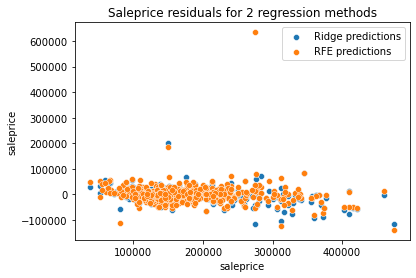

In [298]:
sns.scatterplot(y_val,np.exp(y_val_ridge)-y_val)
sns.scatterplot(y_val,y_val_pred-y_val)
plt.legend(['Ridge predictions','RFE predictions'])
plt.title('Saleprice residuals for 2 regression methods')

Say what you will, there's no heteroskedasticity in either of those charts- thanks to the log transform. The reason for ad-hoc using np.log and np.exp is that ttr often doesn't spit out the feature_names or work as nicely with the other parts of the set

In [192]:
ct1.get_feature_names()

C:\Users\Karthik\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['onehotencoder__ms_zoning_1',
 'onehotencoder__ms_zoning_2',
 'onehotencoder__ms_zoning_3',
 'onehotencoder__ms_zoning_4',
 'onehotencoder__ms_zoning_5',
 'onehotencoder__ms_zoning_6',
 'onehotencoder__ms_zoning_7',
 'onehotencoder__utilities_1',
 'onehotencoder__utilities_2',
 'onehotencoder__utilities_3',
 'onehotencoder__lot_config_1',
 'onehotencoder__lot_config_2',
 'onehotencoder__lot_config_3',
 'onehotencoder__lot_config_4',
 'onehotencoder__lot_config_5',
 'onehotencoder__neighborhood_1',
 'onehotencoder__neighborhood_2',
 'onehotencoder__neighborhood_3',
 'onehotencoder__neighborhood_4',
 'onehotencoder__neighborhood_5',
 'onehotencoder__neighborhood_6',
 'onehotencoder__neighborhood_7',
 'onehotencoder__neighborhood_8',
 'onehotencoder__neighborhood_9',
 'onehotencoder__neighborhood_10',
 'onehotencoder__neighborhood_11',
 'onehotencoder__neighborhood_12',
 'onehotencoder__neighborhood_13',
 'onehotencoder__neighborhood_14',
 'onehotencoder__neighborhood_15',
 'onehotencode

In [193]:
numerics = ['int16', 'int32', 'int64','float16','float32','float64']
X_train.select_dtypes(include=numerics)

,lot_area,year_built,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,totrms_abvgrd,fireplaces,garage_cars,garage_area,screen_porch,pool_area,misc_val,mo_since_1990
1733,8.976768,1999,953.0,953,694,7.406711,0.0,0.0,2,1,3,1,7,1,2.0,460.0,0,0,0,212
258,9.270023,1900,978.0,1014,685,7.437795,1.0,0.0,2,0,3,2,7,0,2.0,420.0,0,0,0,236
902,9.077951,2006,1489.0,1500,0,7.313220,0.0,0.0,2,0,3,1,7,1,2.0,674.0,0,0,0,210
450,9.035987,1968,833.0,898,0,6.800170,1.0,0.0,1,0,3,1,6,0,1.0,326.0,0,0,0,200
1706,9.186048,1963,1395.0,1395,0,7.240650,1.0,0.0,1,0,2,1,7,1,2.0,440.0,240,0,0,245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,9.114270,1941,616.0,616,495,7.013016,0.0,1.0,1,0,3,1,5,0,1.0,200.0,0,0,0,219
1006,9.694370,1998,1028.0,1210,1242,7.804659,0.0,0.0,2,1,4,1,9,1,2.0,683.0,0,0,0,209
953,9.131838,2006,939.0,939,858,7.493874,0.0,0.0,2,1,3,1,8,0,2.0,639.0,0,0,0,208
725,8.106515,2005,1247.0,1247,0,7.128496,1.0,0.0,1,1,1,1,4,1,2.0,550.0,0,0,0,196


With thanks to https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-pandas

So, just as said on the get_columns name, there are 20 rows (0-19) as said in those column names. Let's try and use a dictionary to get them to something more usable

In [194]:
X_train.select_dtypes(include=numerics).columns[0]

'lot_area'

In [195]:
x_oh_dict = {'x'+str(num) : X_train.select_dtypes(include=numerics).columns[num] for num in list(range(20))}

In [196]:
colnames = ct1.get_feature_names()
for key,value in x_oh_dict.items():
    colnames = [col.replace(key,value) for col in colnames]

C:\Users\Karthik\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [197]:
x_oh_dict

{'x0': 'lot_area',
 'x1': 'year_built',
 'x2': 'total_bsmt_sf',
 'x3': '1st_flr_sf',
 'x4': '2nd_flr_sf',
 'x5': 'gr_liv_area',
 'x6': 'bsmt_full_bath',
 'x7': 'bsmt_half_bath',
 'x8': 'full_bath',
 'x9': 'half_bath',
 'x10': 'bedroom_abvgr',
 'x11': 'kitchen_abvgr',
 'x12': 'totrms_abvgrd',
 'x13': 'fireplaces',
 'x14': 'garage_cars',
 'x15': 'garage_area',
 'x16': 'screen_porch',
 'x17': 'pool_area',
 'x18': 'misc_val',
 'x19': 'mo_since_1990'}

It's just now clear that trying to replace will turn all the 'x10's into value(x1)0, so let's fix that

In [198]:
secret_dict = {'year_built'+str(num):x_oh_dict.get('x1'+str(num)) for num in list(range(10))}

In [199]:
for key,value in secret_dict.items():
    colnames = [col.replace(key,value) for col in colnames]

This removes the ugly-looking mention of where the model came from and keeps us just to the important variables

In [200]:
new_cols = []
for col in colnames:
    a,b = col.split('__')
    new_cols.append(b)

In [201]:
rfe.get_feature_names_out()

array(['ms_zoning_6', 'lot_area', 'utilities_1', 'utilities_2',
       'neighborhood_2', 'neighborhood_4', 'neighborhood_6',
       'neighborhood_7', 'neighborhood_8', 'neighborhood_9',
       'neighborhood_10', 'neighborhood_12', 'neighborhood_13',
       'neighborhood_14', 'neighborhood_17', 'neighborhood_20',
       'neighborhood_21', 'neighborhood_24', 'neighborhood_25',
       'neighborhood_28', 'heating_1', 'heating_4', 'heating_5',
       'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'kitchen_abvgr',
       'garage_type_2', 'garage_type_3', 'garage_type_4', 'garage_cars',
       'pool_qc_1', 'pool_qc_2', 'pool_qc_3', 'pool_qc_4', 'pool_qc_5',
       'misc_feature_1', 'misc_feature_2', 'misc_feature_3',
       'misc_feature_4', 'misc_feature_5', 'misc_feature_6',
       'sale_type_2', 'sale_type_7'], dtype=object)

In [202]:
X_train_pd_ct = pd.DataFrame(ct1.transform(X_train),columns=new_cols)

In [203]:
rfe2 = RFE(LinearRegression(),n_features_to_select=.3)

In [204]:
X_train_rfe2 = pd.DataFrame(rfe2.fit_transform(X_train_pd_ct,y_train),columns=rfe2.get_feature_names_out())

In [205]:
X_train_rfe2

,ms_zoning_1,ms_zoning_2,ms_zoning_4,ms_zoning_5,ms_zoning_6,utilities_1,utilities_2,lot_config_1,lot_config_3,lot_config_4,...,bsmt_half_bath full_bath,bsmt_half_bath kitchen_abvgr,bsmt_half_bath totrms_abvgrd,bsmt_half_bath fireplaces,full_bath half_bath,full_bath garage_cars,bedroom_abvgr fireplaces,bedroom_abvgr garage_cars,kitchen_abvgr garage_cars,fireplaces garage_cars
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,4.0,3.0,6.0,2.0,2.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,6.0,4.0,0.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,3.0,6.0,2.0,2.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,2.0,4.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1530,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,5.0,0.0,0.0,1.0,0.0,3.0,1.0,0.0
1531,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,4.0,4.0,8.0,2.0,2.0
1532,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,4.0,0.0,6.0,2.0,0.0
1533,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0,2.0,2.0


In [206]:
np.corrcoef(x= X_train_rfe2.iloc[:,[0]],y = pd.DataFrame(np.log(y_train)),rowvar=False).ravel()[1]

0.2804525355789457

In [207]:
X_train_rfe2.iloc[:,[0]].shape, pd.DataFrame(np.log(y_train)).shape

((1535, 1), (1535, 1))

In [208]:
correlations = {X_train_rfe2.columns[num]:np.corrcoef(x= X_train_rfe2.iloc[:,[num]],y = pd.DataFrame(np.log(y_train)),rowvar=False).ravel()[1] for num in list(range(90))}

In [209]:
df_corr = pd.DataFrame([(key,value) for key,value in correlations.items()])

In [210]:
df_corr.set_axis(axis='columns',labels=['variable','R2_score'],inplace=True)

In [211]:
df_corr['absolute_score']=df_corr['R2_score'].abs()

One way to look at 'most important variables' is their R2 score. We'll also look at their normalized correlation coefficient later, which also applies, but this can also be useful to help assess.

In [213]:
df_corr.sort_values(by='absolute_score',ascending=False).head(15)

,variable,R2_score,absolute_score
58,gr_liv_area,0.715155,0.715155
85,full_bath garage_cars,0.712534,0.712534
75,gr_liv_area garage_cars,0.697785,0.697785
70,lot_area garage_cars,0.677113,0.677113
66,garage_cars,0.660907,0.660907
67,lot_area gr_liv_area,0.621572,0.621572
89,fireplaces garage_cars,0.607709,0.607709
71,gr_liv_area full_bath,0.596143,0.596143
87,bedroom_abvgr garage_cars,0.572692,0.572692
61,full_bath,0.558699,0.558699


In [216]:
lr2.fit(X_train_rfe2,np.log(y_train))
predicts = lr2.predict(X_train_rfe2)

In [217]:
X_train_finalss= ss.fit_transform(X_train_rfe2,y_train)

In [218]:
pdX_train_finalss = pd.DataFrame(X_train_finalss,columns=ss.get_feature_names_out()).drop(columns=['paved_drive_1','central_air_1'])
lr2.fit(pdX_train_finalss,np.log(y_train))
predicts = lr2.predict(pdX_train_finalss)
mean_squared_error(y_train,np.exp(predicts))**0.5

27509.677912094907

In [219]:
pred_coefs = pd.DataFrame(list(zip(pdX_train_finalss.columns,lr2.coef_)),columns=['features','linear_coefs'])

In [220]:
pred_coefs['abs_coefs'] = pred_coefs['linear_coefs'].abs()

In [221]:
pred_coefs.sort_values(by='abs_coefs',ascending=False).head(25)

,features,linear_coefs,abs_coefs
65,lot_area gr_liv_area,-1.068655,1.068655
55,lot_area,0.671565,0.671565
56,gr_liv_area,0.666528,0.666528
64,garage_cars,-0.514918,0.514918
69,gr_liv_area full_bath,0.376385,0.376385
73,gr_liv_area garage_cars,0.368800,0.368800
59,full_bath,-0.331302,0.331302
68,lot_area garage_cars,0.291849,0.291849
72,gr_liv_area fireplaces,0.280799,0.280799
67,lot_area bedroom_abvgr,0.236952,0.236952


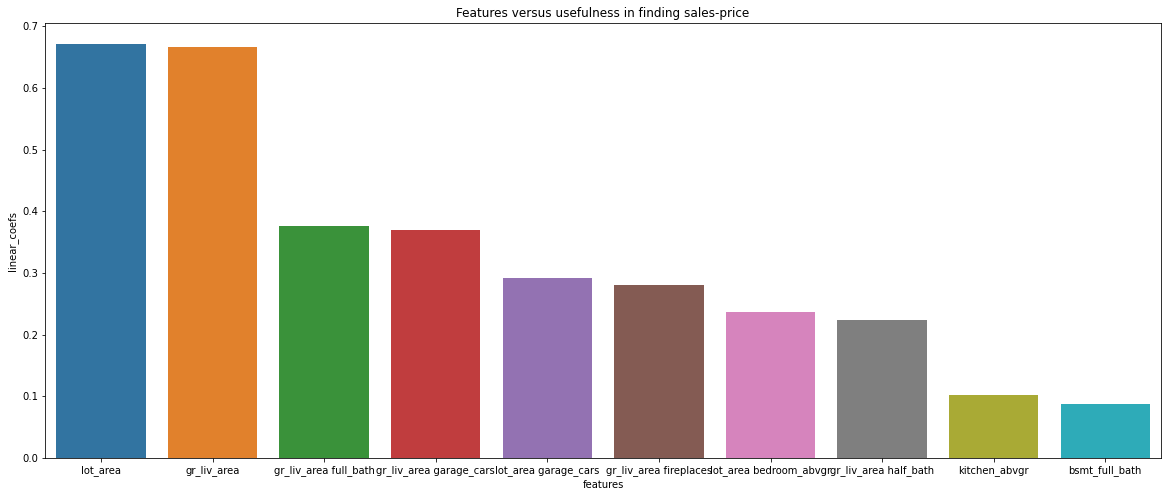

In [222]:
plt.figure(figsize=(20,8))
sns.barplot(data=pred_coefs.sort_values(by='linear_coefs',ascending=False).head(10),x='features',y='linear_coefs')
plt.title('Features versus usefulness in finding sales-price')
plt.savefig('Best_coefs.png')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year_built', ylabel='saleprice'>

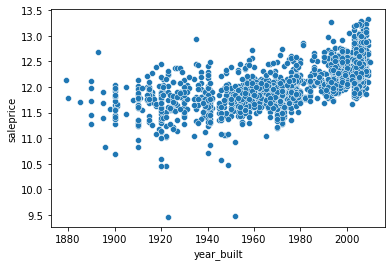

In [223]:
sns.scatterplot(X_train['year_built'],np.log(y_train))


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='saleprice'>

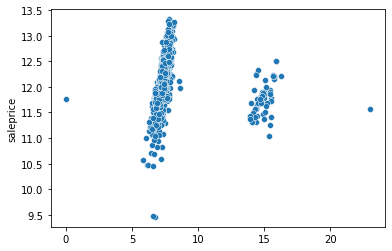

In [224]:
sns.scatterplot(X_train['gr_liv_area']*X_train['kitchen_abvgr'],np.log(y_train))

From the information we have, we can identify various important variables, like lot size, area, garages, number of baths, etc, and many that essentially repeat this. Let's try this modeling with only a couple variables, and see what other information we can get

In [225]:
X_train.columns

Index(['ms_zoning', 'lot_area', 'utilities', 'lot_config', 'neighborhood',
       'bldg_type', 'year_built', 'total_bsmt_sf', 'heating', 'central_air',
       '1st_flr_sf', '2nd_flr_sf', 'gr_liv_area', 'bsmt_full_bath',
       'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr',
       'kitchen_abvgr', 'totrms_abvgrd', 'fireplaces', 'garage_type',
       'garage_cars', 'garage_area', 'paved_drive', 'screen_porch',
       'pool_area', 'pool_qc', 'fence', 'misc_feature', 'misc_val',
       'sale_type', 'mo_since_1990'],
      dtype='object')

In [226]:
X_traintoo = X_train[['ms_zoning','lot_area','neighborhood','garage_cars','gr_liv_area','kitchen_abvgr']]
X_valtoo = X_val[['ms_zoning','lot_area','neighborhood','garage_cars','gr_liv_area','kitchen_abvgr']]

In [227]:
from sklearn.preprocessing import OneHotEncoder


In [228]:
ct2 = make_column_transformer((OneHotEncoder(drop='first',sparse=False),make_column_selector(dtype_include=object)),remainder='passthrough')

In [229]:
X_traintoo_ct = pd.DataFrame(ct2.fit_transform(X_traintoo,y_train),columns=ct2.get_feature_names_out())

In [230]:
ss3 = StandardScaler()
X_traintoo_ss = ss3.fit_transform(X_traintoo_ct)
lr3 = LinearRegression()
lr3.fit(X_traintoo_ss,np.log(y_train))
y_predicttoo = lr3.predict(X_traintoo_ss)

In [231]:
mean_squared_error(y_train,np.exp(y_predicttoo))**0.5

36058.302736908896

Worse than before, but we are working with a smaller deck to try and tease out some insights

In [232]:
X_valtoo_ct = pd.DataFrame(ct2.transform(X_valtoo),columns=ct2.get_feature_names_out())
X_valtoo_ss = ss3.transform(X_valtoo_ct)
y_valpredicttoo = lr3.predict(X_valtoo_ss)

In [233]:
mean_squared_error(y_val,np.exp(y_valpredicttoo))**0.5

30858.8965344325

In [234]:
pred_coefsplus = pd.DataFrame(list(zip(X_traintoo_ct.columns,lr3.coef_)),columns=['features','linear_coefs'])

In [235]:
pred_coefsplus.sort_values(by='linear_coefs',ascending=False)


,features,linear_coefs
4,onehotencoder__ms_zoning_RL,0.781166
5,onehotencoder__ms_zoning_RM,0.696001
1,onehotencoder__ms_zoning_FV,0.396285
35,remainder__gr_liv_area,0.176708
0,onehotencoder__ms_zoning_C (all),0.168518
3,onehotencoder__ms_zoning_RH,0.149423
34,remainder__garage_cars,0.065567
33,remainder__lot_area,0.042399
24,onehotencoder__neighborhood_NridgHt,0.039810
2,onehotencoder__ms_zoning_I (all),0.037763


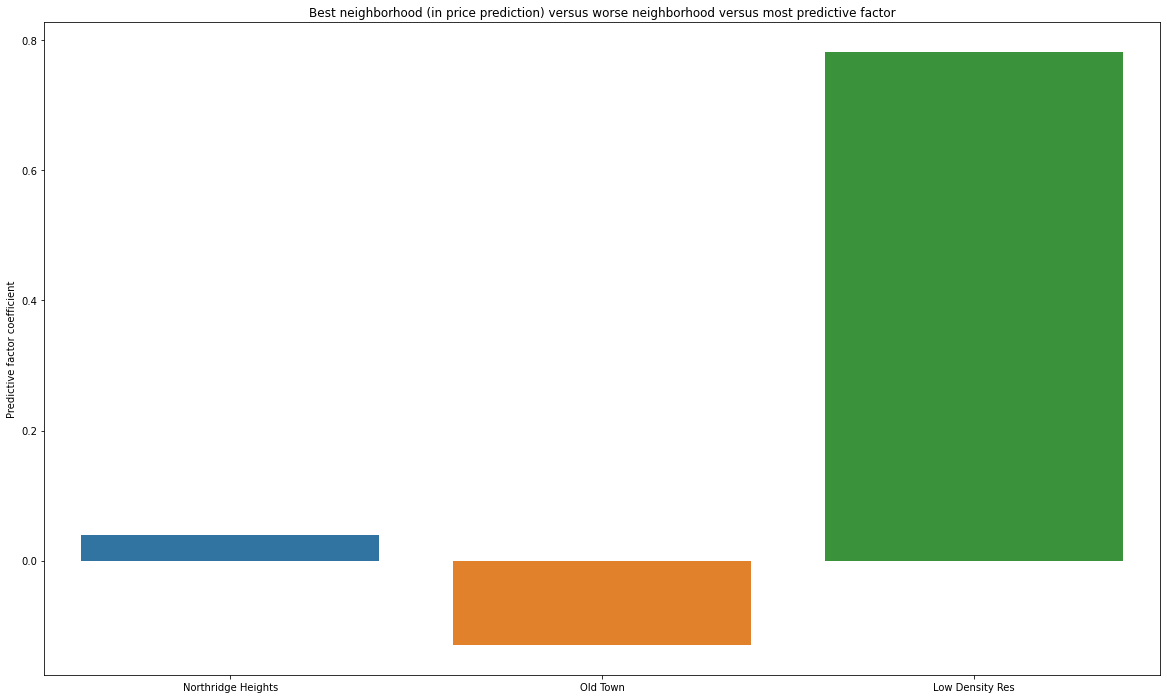

In [236]:
plt.figure(figsize=(20,12))
sns.barplot(x=['Northridge Heights','Old Town','Low Density Res'],y=[.039810,-.129871,0.781666])
plt.title('Best neighborhood (in price prediction) versus worse neighborhood versus most predictive factor')
plt.ylabel('Predictive factor coefficient')
plt.savefig('nabe.png')

From this graph, we can see that the difference in this predictive factor coefficient (relative to Bloomington Heights, which was dropped) which is already standardized so that one SD conrresponds perfectly here- we can see that even the largest range of differences between neighborhoods pales in comparison to the predictiveness of living in a Low Density Residentially zoned area for house prices

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


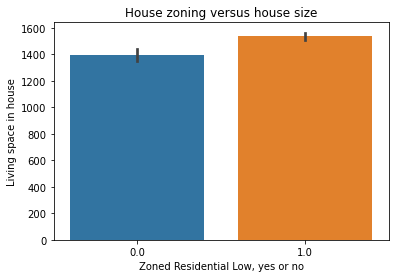

In [237]:
sns.barplot(X_traintoo_ct['onehotencoder__ms_zoning_RL'],np.exp(X_traintoo_ct['remainder__gr_liv_area']))
plt.xlabel('Zoned Residential Low, yes or no')
plt.ylabel('Living space in house')
plt.title('House zoning versus house size')
plt.savefig('Zoning.png')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'Res Low Density'),
 Text(1, 0, 'Res Med Density'),
 Text(2, 0, 'Floating Village'),
 Text(3, 0, 'Comercial'),
 Text(4, 0, 'Agri'),
 Text(5, 0, 'Res High Density'),
 Text(6, 0, 'Industrial')]

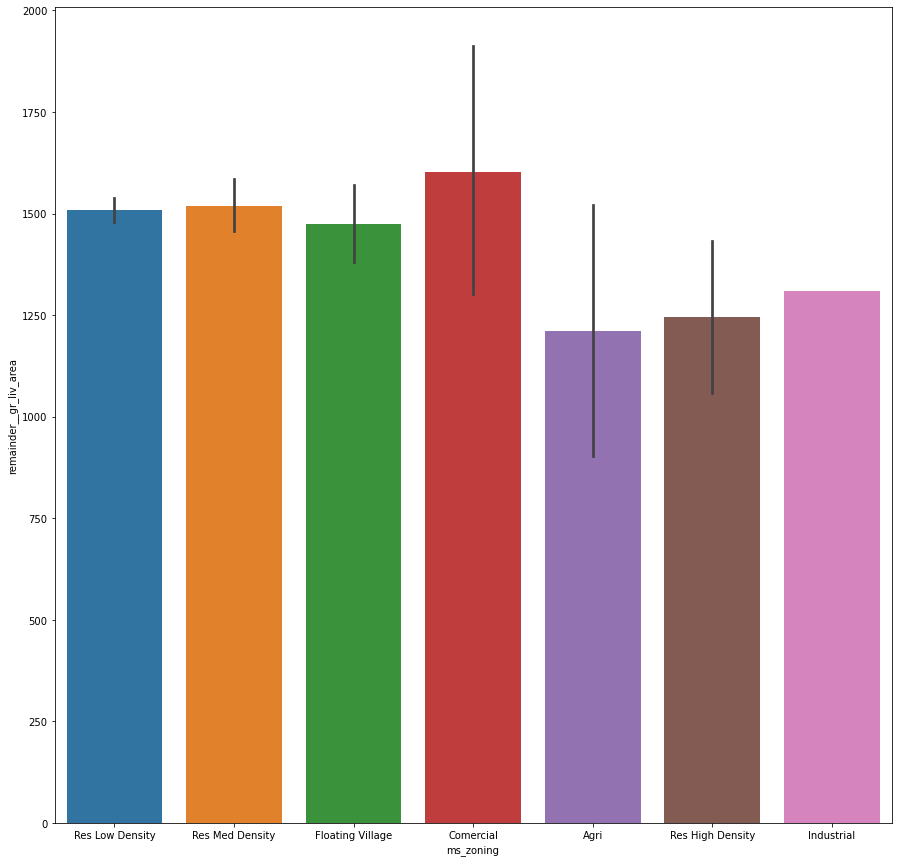

In [240]:
figure, ax = plt.subplots(1,1)
figure.set_figheight(15)
figure.set_figwidth(15)
sns.barplot(ames_train['ms_zoning'],np.exp(X_traintoo_ct['remainder__gr_liv_area']),ax=ax)
ax.set_xticklabels(labels=['Res Low Density','Res Med Density','Floating Village','Comercial','Agri','Res High Density', 'Industrial'])